# Анализ данных премии Оскар
## Цели и задачи проекта

**Цель:** Проанализировать исторические данные о номинациях и победах на премии Оскар, выявить ключевые тенденции и построить модель прогнозирования побед.

**Гипотезы:**
1. Доля технических номинаций растет с развитием кинематографических технологий
2. Существуют "вечные номинанты" - люди с большим количеством номинаций без побед
3. Кинокомпании-лидеры менялись в разные исторические периоды
4. Процент побед варьируется в разные десятилетия
5. Предыдущий опыт номинаций влияет на вероятность победы

**Стек технологий:** Python, Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn

**Данные:** The Oscar Award dataset (Kaggle)

## 1. Импорт библиотек и загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv('/content/the_oscar_award.csv')
print(f"Размер датасета: {df.shape}")
print(f"Период данных: {df['year_ceremony'].min()} - {df['year_ceremony'].max()}")
print("\nПервые 5 строк:")
print(df.head())

Размер датасета: (11110, 8)
Период данных: 1928 - 2025

Первые 5 строк:
   year_film  year_ceremony  ceremony category             canon_category  \
0       1927           1928         1    ACTOR    ACTOR IN A LEADING ROLE   
1       1927           1928         1    ACTOR    ACTOR IN A LEADING ROLE   
2       1927           1928         1    ACTOR    ACTOR IN A LEADING ROLE   
3       1927           1928         1    ACTOR    ACTOR IN A LEADING ROLE   
4       1927           1928         1  ACTRESS  ACTRESS IN A LEADING ROLE   

                  name                    film  winner  
0  Richard Barthelmess               The Noose   False  
1  Richard Barthelmess  The Patent Leather Kid   False  
2        Emil Jannings        The Last Command    True  
3        Emil Jannings    The Way of All Flesh    True  
4       Louise Dresser         A Ship Comes In   False  


## 2. Предобработка данных

In [ ]:
print("Проверка данных перед обработкой:")
print(f"Пропуски в данных:")
print(df.isnull().sum())
print(f"\nТипы данных:")
print(df.dtypes)

Проверка данных перед обработкой:
Пропуски в данных:
year_film           0
year_ceremony       0
ceremony            0
category            0
canon_category      0
name                7
film              359
winner              0
dtype: int64

Типы данных:
year_film          int64
year_ceremony      int64
ceremony           int64
category          object
canon_category    object
name              object
film              object
winner              bool
dtype: object


In [ ]:
# Создаем признаки для анализа

# Десятилетия для временного анализа
df['decade'] = pd.cut(df['year_ceremony'], bins=range(1920, 2031, 10))

# Периоды кинематографа
eras = pd.cut(df['year_ceremony'], bins=[1927, 1950, 1970, 1990, 2010, 2025],
              labels=['Классический Голливуд', 'Золотой век', 'Новый Голливуд',
                      'Эпоха блокбастеров', 'Современный период'])
df['era'] = eras

# Классификация категорий
def classify_category(cat):
  creative_keywords = ['ACTOR', 'ACTRESS', 'DIRECTOR', 'WRIT', 'PICTURE', 'MUSIC', 'DESIGN']
  technical_keywords = ['SOUND', 'EFFECT', 'EDIT', 'CINEMATO', 'MAKEUP', 'SHORT', 'DOCUMENT',
                      'TECHNICAL', 'ENGINEER']
  if any(i in cat for i in creative_keywords):
      return 'Творческая'
  elif any(i in cat for i in technical_keywords):
      return 'Техническая'
  else:
      return 'Специальная'
df['category_type'] = df['category'].apply(classify_category)

# Флаг актерских номинаций
def actor_category(cat):
    if ('ACTOR' in cat) or ('ACTRESS' in cat):
        return True
    return False
df['actor_actress'] = df['category'].apply(actor_category)

# Гендерная принадлежность актерской категории
def male_female_category(cat):
    if 'ACTRESS' in cat:
        return 'female'
    elif 'ACTOR' in cat:
        return 'male'
    else:
        return 'not actress/actor'
df['gender'] = df['category'].apply(male_female_category)

# Флаг режиссерских номинаций
def is_director(cat):
    if 'DIRECT' in cat:
        return True
    return False
df['is_director'] = df['category'].apply(is_director)

# Флаг студийных категорий
def is_studio(cat):
    studio_categories = [
    'BEST PICTURE',
    'OUTSTANDING PICTURE',
    'UNIQUE AND ARTISTIC PICTURE',
    'OUTSTANDING PRODUCTION',
    'BEST MOTION PICTURE',
    'BEST ANIMATED FEATURE FILM',
    'BEST DOCUMENTARY FEATURE',
    'BEST INTERNATIONAL FEATURE FILM',
    'BEST LIVE ACTION SHORT FILM',
    'BEST ANIMATED SHORT FILM',
    'BEST DOCUMENTARY SHORT SUBJECT'
    ]
    if any(i in cat for i in studio_categories):
        return True
    return False
df['is_studio'] = df['category'].apply(is_studio)

# Флаг основных категорий
def is_major_category(cat):
  categories_keywords = [
        'PICTURE', 'PICTURE', 'PRODUCTION', 'DIRECT',
        'ACTOR', 'ACTRESS', 'SCREENPLAY'
    ]
  if any(i in cat for i in categories_keywords):
    return True
  return False
df['is_major_cat'] = df['category'].apply(is_major_category)

## 3. Exploratory Data Analysis (EDA)

##3.1. Общая статистика номинаций и побед

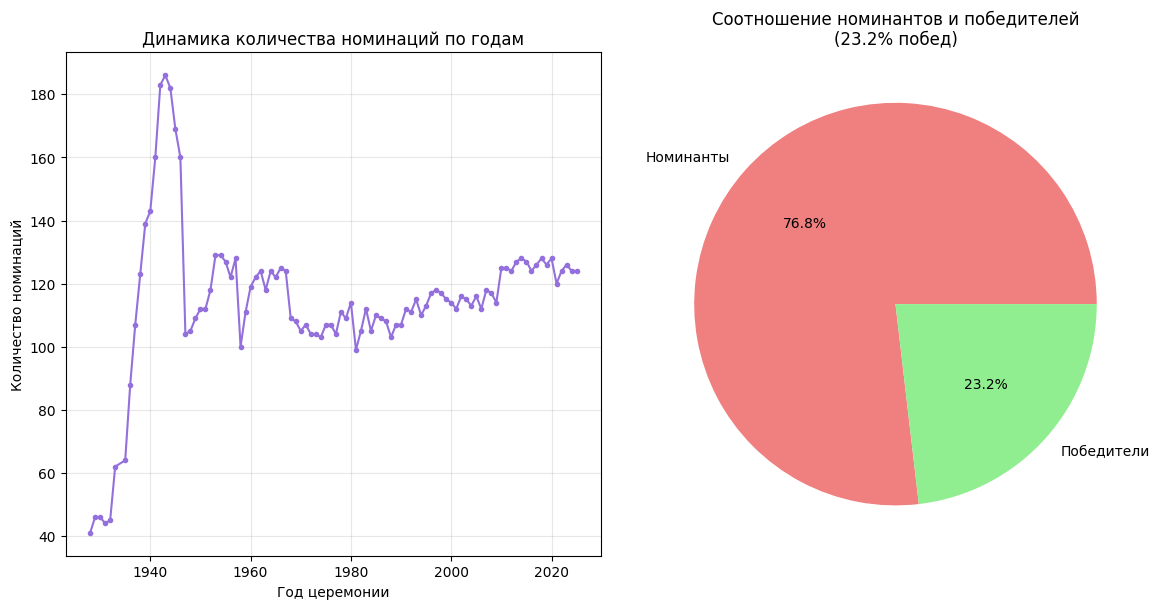

In [ ]:
# Динамика количества номинаций по годам
nominations_by_year = df.groupby('year_ceremony').size()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(nominations_by_year.index, nominations_by_year.values, marker='o',
         markersize=3, color='mediumpurple')
plt.title('Динамика количества номинаций по годам', fontsize=12)
plt.xlabel('Год церемонии')
plt.ylabel('Количество номинаций')
plt.grid(True, alpha=0.3)

# Процент победителей
plt.subplot(1, 2, 2)
percent_of_wins = (len(df[df['winner']==True])/len(df))*100
win_data = df['winner'].value_counts()
colors = ['lightcoral', 'lightgreen']
plt.pie(win_data.values, labels=['Номинанты', 'Победители'], autopct='%1.1f%%', colors=colors)
plt.title(f'Соотношение номинантов и победителей\n({percent_of_wins:.1f}% побед)', fontsize=12)
plt.tight_layout()
plt.show()

**Вывод:** Только около 23% номинаций заканчиваются победой, что говорит о высокой конкурентности премии.

##3.2. Эволюция категорий премии

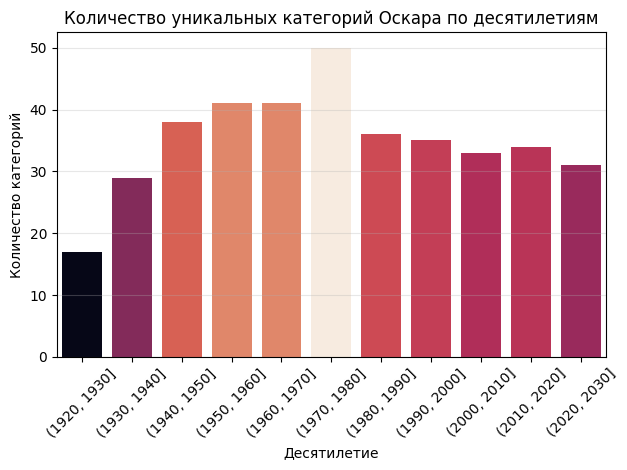

In [ ]:
# кол-во уникальных категорий в каждом десятилетии
decade_categories = df.groupby('decade', observed=True)['category'].nunique().reset_index(name='unique_categories')
sns.barplot(data=decade_categories, x='decade', y='unique_categories', hue='unique_categories', legend=False, palette='rocket')
plt.title('Количество уникальных категорий Оскара по десятилетиям', fontsize=12)
plt.xlabel('Десятилетие')
plt.ylabel('Количество категорий')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

##3.3. Стабильность категорий Оскара

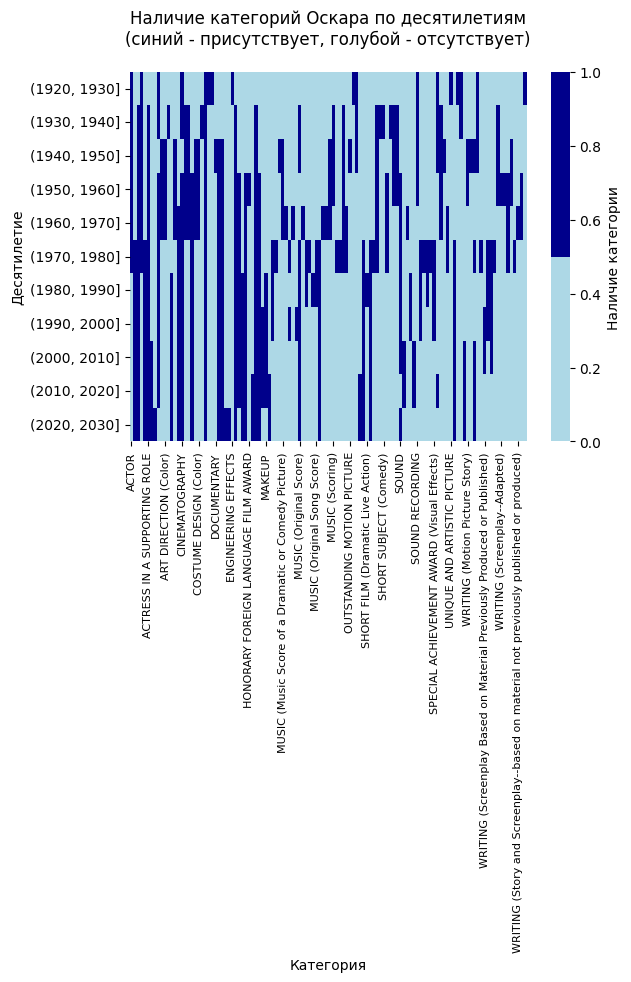

In [ ]:
category_stability = df.groupby('category', observed=True)['decade'].nunique().reset_index(name='years')
stability_table = df.groupby(['decade', 'category'], observed=True).size().unstack(fill_value=0)
stability_table = (stability_table>0)
sns.heatmap(stability_table, cmap=['lightblue', 'darkblue'], cbar_kws={'label': 'Наличие категории'})
plt.title('Наличие категорий Оскара по десятилетиям\n(синий - присутствует, голубой - отсутствует)',
          fontsize=12, pad=20)
plt.xlabel('Категория')
plt.ylabel('Десятилетие')
plt.xticks(rotation=90, fontsize=8)
plt.show()

**Вывод:** Heatmap наглядно показывает эволюцию категорийного состава премии. Основные актерские и режиссерские номинации остаются стабильными на протяжении всей истории, в то время как технические категории постоянно меняются и добавляются, отражая развитие киноиндустрии.

##3.4. Анализ конкурентности категорий

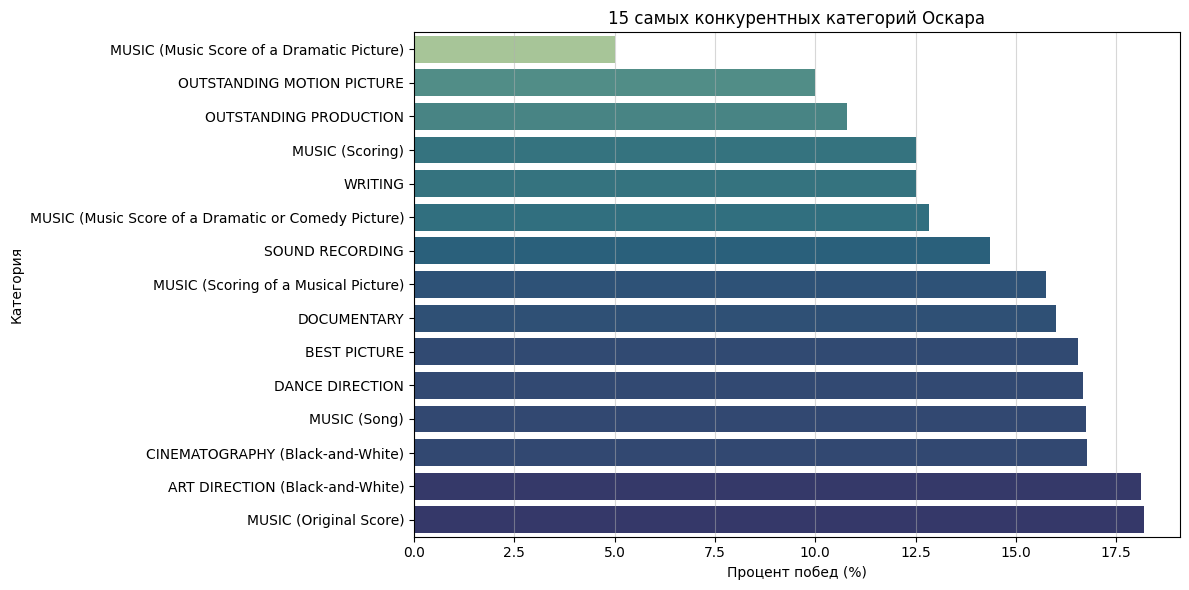

In [ ]:
category_difficulty = df.groupby('category').agg(
    nominations=('winner', 'count'),
    wins=('winner', 'sum')
).reset_index().sort_values(by='nominations', ascending=False)
category_difficulty['win_rate'] = (100*category_difficulty['wins']/category_difficulty['nominations']).round(2)
most_competitive = category_difficulty[category_difficulty['nominations']>10].sort_values(by='win_rate').head(15)
plt.figure(figsize=(12, 6))
sns.barplot(data=most_competitive, x='win_rate', y='category', hue='win_rate', palette='crest', legend=False)
plt.title('15 самых конкурентных категорий Оскара')
plt.xlabel('Процент побед (%)')
plt.ylabel('Категория')
plt.grid(axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

**Выводы:**

##3.5. Распределение номинаций по историческим периодам
Анализируем, как количество номинаций распределено по разным эпохам кинематографа. Это покажет, в какие периоды премия Оскар была наиболее активной.

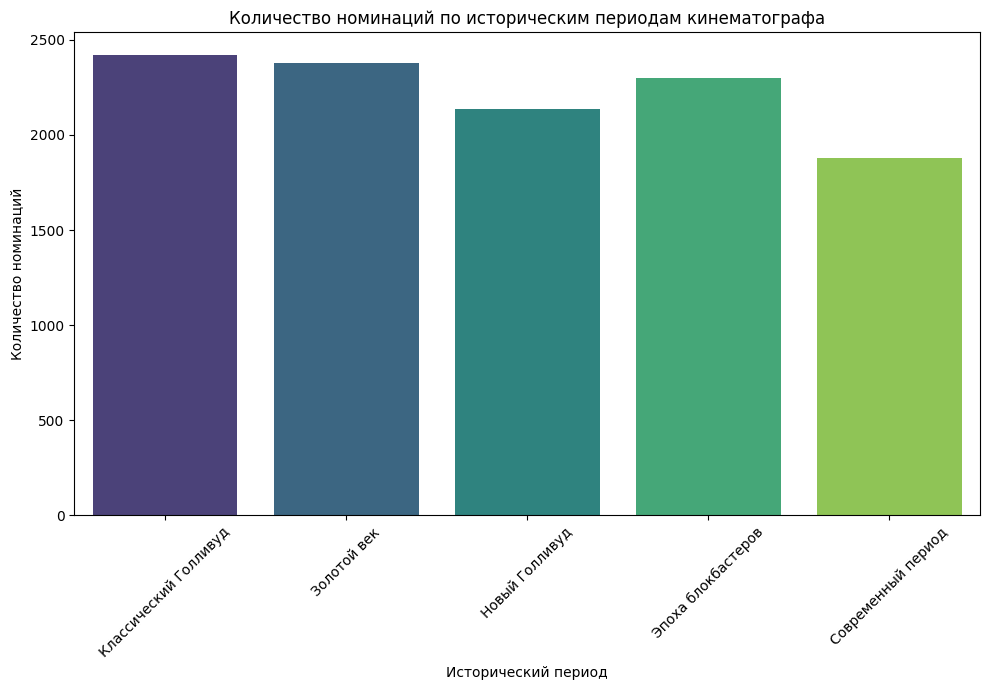

In [ ]:
eras_df = df.groupby('era', observed=True).size().reset_index(name='count_of_nominations')
plt.figure(figsize=(10, 7))
sns.barplot(data=eras_df, x='era', y='count_of_nominations', hue='era', palette='viridis', legend=False)
plt.title('Количество номинаций по историческим периодам кинематографа')
plt.xlabel('Исторический период')
plt.ylabel('Количество номинаций')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##3.6. Распределение категорий по типам

Распределение категорий по типам:
Специальная: 26 категорий (22.0%)
Творческая: 59 категорий (50.0%)
Техническая: 33 категорий (28.0%)


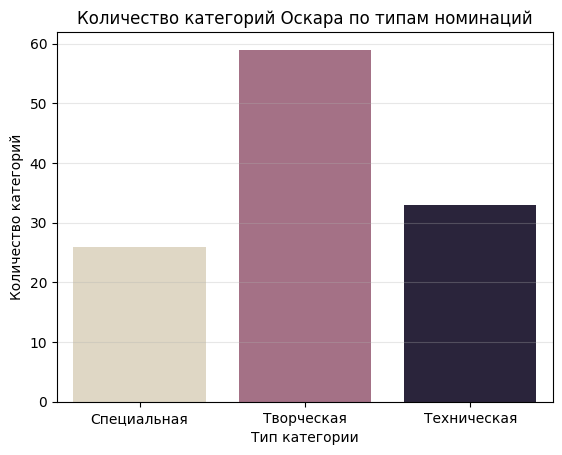

In [ ]:
categories_types_count = df.groupby('category_type', observed=True)['category'].nunique().reset_index(name='count')
sns.barplot(data=categories_types_count, x='category_type', y='count', hue='category_type',
            palette='ch:s=-.2,r=.6', legend=False)
plt.title('Количество категорий Оскара по типам номинаций')
plt.xlabel('Тип категории')
plt.ylabel('Количество категорий')
plt.grid(axis='y', alpha=0.3)

total_categories = categories_types_count['count'].sum()
print('Распределение категорий по типам:')
for _, i in categories_types_count.iterrows():
  cat_type_percentage = 100*i['count']/total_categories
  print(f'{i['category_type']}: {i['count']} категорий ({cat_type_percentage:.1f}%)')

##3.7. Эволюция доли категорий по типам во времени
Анализируем, как менялось соотношение творческих, технических и специальных номинаций в разные десятилетия. Heatmap показывает долю каждого типа категорий в общем количестве номинаций за десятилетие.

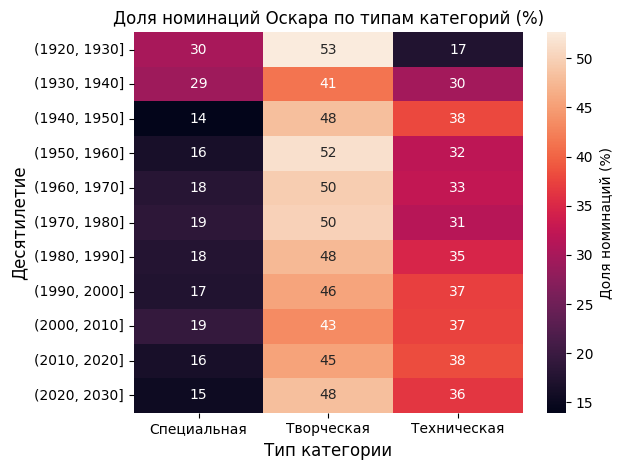

Специальная: cнижение на 14.7%
Творческая: cнижение на 4.4%
Техническая: рост на 19.1%


In [ ]:
count_by_decades = df.groupby('decade', observed=True).size()
nominations_by_type = df.groupby(['decade', 'category_type'], observed=True).size()
percent_table = (100*nominations_by_type / count_by_decades).unstack(fill_value=0)
sns.heatmap(data=percent_table, annot=True, cbar_kws={'label': 'Доля номинаций (%)'})
plt.title('Доля номинаций Оскара по типам категорий (%)')
plt.xlabel('Тип категории', fontsize=12)
plt.ylabel('Десятилетие', fontsize=12)
plt.tight_layout()
plt.show()
for cat in percent_table.columns:
  first = percent_table[cat].iloc[0]
  last = percent_table[cat].iloc[-1]
  change = last - first
  if change < 0:
    print(f'{cat}: cнижение на {abs(change):.1f}%')
  else:
    print(f'{cat}: рост на {abs(change):.1f}%')

##3.8. Анализ побед по типам категорий
Исследуем, как процент побед распределен между творческими, техническими и специальными категориями в разные десятилетия. Это покажет, в каких типах номинаций конкурентность менялась со временем.

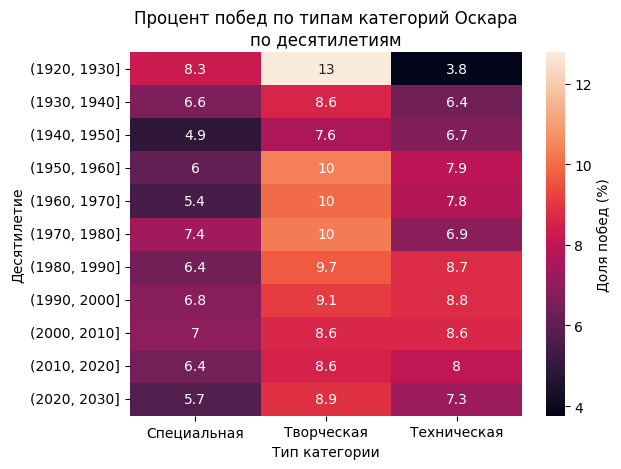


Специальная категория:
Максимум: 8.3% в (1920, 1930]
Минимум: 4.9% в (1940, 1950]
Среднее: 6.4

Творческая категория:
Максимум: 12.8% в (1920, 1930]
Минимум: 7.6% в (1940, 1950]
Среднее: 9.5

Техническая категория:
Максимум: 8.8% в (1990, 2000]
Минимум: 3.8% в (1920, 1930]
Среднее: 7.4


In [ ]:
cat_types_wins = df[df['winner']==True].groupby(['decade', 'category_type'], observed=True).size()
percent_table_wins_type = (100*cat_types_wins / count_by_decades).unstack(fill_value=0)
sns.heatmap(percent_table_wins_type, annot=True, cbar_kws={'label': 'Доля побед (%)'})
plt.title('Процент побед по типам категорий Оскара\nпо десятилетиям')
plt.xlabel('Тип категории')
plt.ylabel('Десятилетие')
plt.tight_layout()
plt.show()

for cat in percent_table_wins_type.columns:
  max_decade = percent_table_wins_type[cat].idxmax()
  max_value = percent_table_wins_type[cat].max()
  min_decade = percent_table_wins_type[cat].idxmin()
  min_value = percent_table_wins_type[cat].min()

  print(f"\n{cat} категория:")
  print(f"Максимум: {max_value:.1f}% в {max_decade}")
  print(f"Минимум: {min_value:.1f}% в {min_decade}")
  print(f'Среднее: {percent_table_wins_type[cat].mean():.1f}')

##3.9. Анализ фильмов-лидеров по наградам Оскар

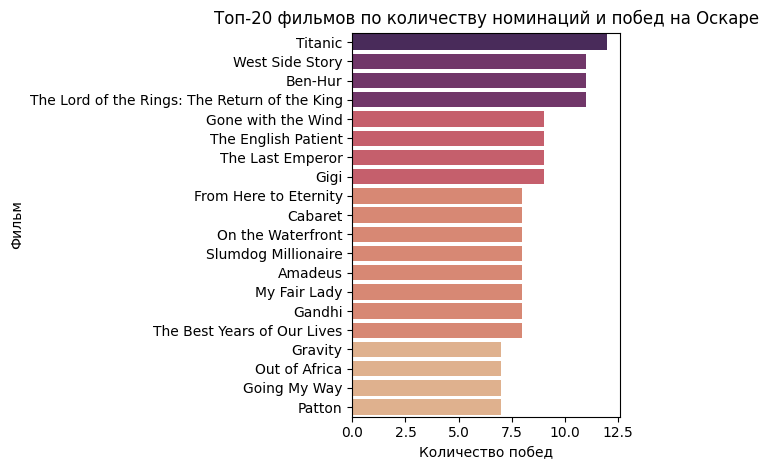

In [ ]:
movies_stats = df.groupby('film', observed=True).agg(
    nominations=('winner', 'count'),
    wins=('winner', 'sum')
).sort_values(by='wins', ascending=False).head(20)

sns.barplot(data=movies_stats, x='wins', y='film', hue='wins', palette='flare', legend=False)
plt.title('Топ-20 фильмов по количеству номинаций и побед на Оскаре')
plt.xlabel('Количество побед')
plt.ylabel('Фильм')
plt.tight_layout()
plt.show()

##3.10. Анализ самых успешных актеров по количеству побед

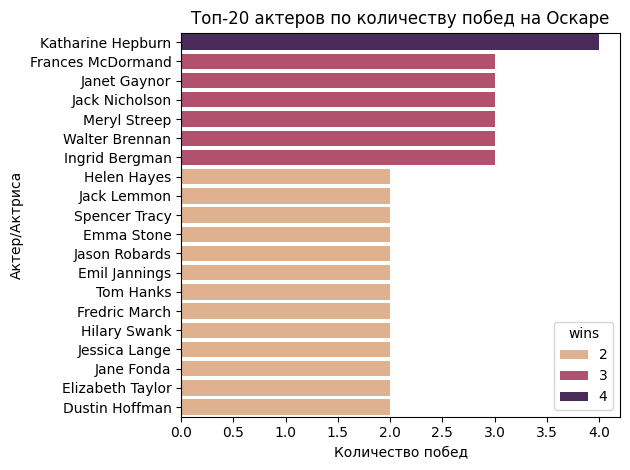

In [ ]:
actors_with_most_wins = df[df['actor_actress']==True].groupby('name', observed=True).agg(
    nominations=('winner', 'count'),
    wins=('winner', 'sum')
).sort_values(by='wins', ascending=False).head(20).reset_index()
sns.barplot(actors_with_most_wins, y='name', x='wins', hue='wins', palette='flare')
plt.title('Топ-20 актеров по количеству побед на Оскаре')
plt.xlabel('Количество побед')
plt.ylabel('Актер/Актриса')
plt.tight_layout()
plt.show()

In [ ]:
eternal_actors = df[df['actor_actress']==True].groupby('name', observed=True).agg(
    nominations=('winner', 'count'),
    wins=('winner', 'sum')
).reset_index().sort_values('nominations', ascending=False)

eternal_actors = eternal_actors[eternal_actors['wins']==0].head(15)
print(eternal_actors)

                  name  nominations  wins
336        Glenn Close            8     0
769      Peter O'Toole            8     0
794     Richard Burton            7     0
925      Thelma Ritter            6     0
212       Deborah Kerr            6     0
27           Amy Adams            6     0
55      Annette Bening            5     0
387        Irene Dunne            5     0
68      Arthur Kennedy            5     0
696  Michelle Williams            5     0
107     Bradley Cooper            5     0
14       Albert Finney            5     0
835   Rosalind Russell            4     0
79    Barbara Stanwyck            4     0
426     Jane Alexander            4     0


##3.11. Гендерное распределение актерских номинаций по десятилетиям

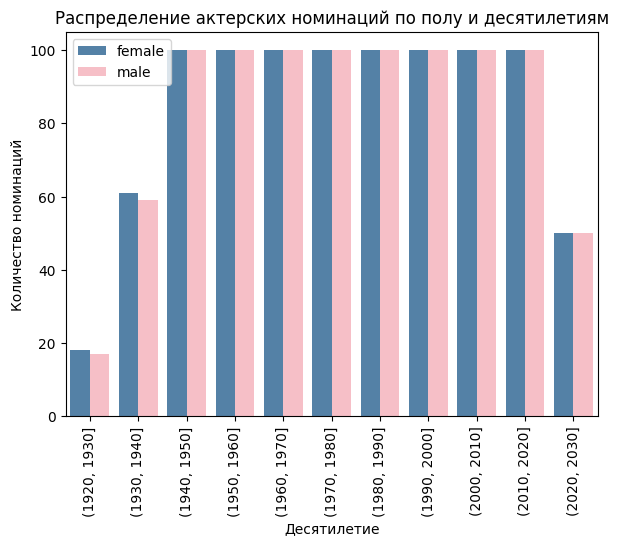

In [ ]:
gender_analysis = df[df['gender']!='not actress/actor'].groupby(['decade', 'gender'], observed=True).size().reset_index(name='count')
sns.barplot(data=gender_analysis, x='decade', y='count', hue='gender', palette=['steelblue', 'lightpink'])
plt.title('Распределение актерских номинаций по полу и десятилетиям')
plt.xlabel('Десятилетие')
plt.ylabel('Количество номинаций')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

##3.12. Анализ эффективности фильмов: соотношение побед и номинаций

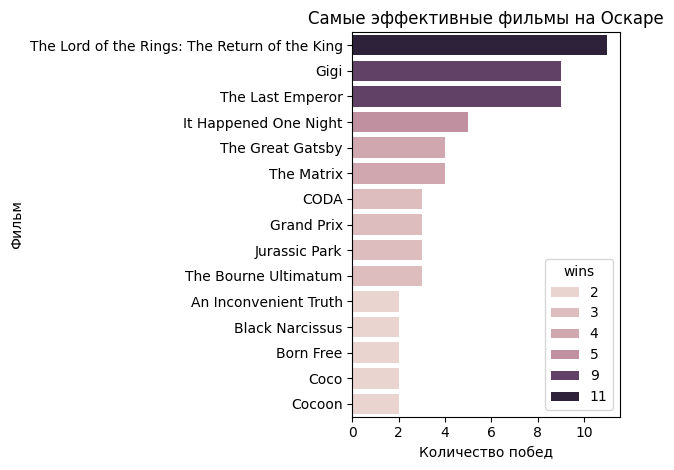

In [ ]:
movies = df.groupby('film', observed=True).agg(
    nominations=('winner', 'count'),
    wins = ('winner', 'sum')
).reset_index()

movies['success'] = 100 * movies['wins']/movies['nominations']

movies_with_most_wins = movies_stats.sort_values(by='wins', ascending=False).head(15)
most_successful_movies = movies.sort_values(
    by=['success', 'nominations'], ascending=[False, False]
).head(15)
sns.barplot(data=most_successful_movies, x='wins', y='film', hue='wins')
plt.title('Самые эффективные фильмы на Оскаре')
plt.xlabel('Количество побед')
plt.ylabel('Фильм')
plt.tight_layout()
plt.show()

##3.13. Анализ режиссерских номинаций и побед


 Топ-15 самых номинируемых режиссеров:
1. William Wyler - 12 номинаций
2. Martin Scorsese - 10 номинаций
3. Steven Spielberg - 9 номинаций
4. Billy Wilder - 8 номинаций
5. Richard Day - 8 номинаций
6. Dante Ferretti/Francesca Lo Schiavo - 8 номинаций
7. Fred Zinnemann - 7 номинаций
8. David Lean - 7 номинаций
9. Woody Allen - 7 номинаций
10. Clarence Brown - 6 номинаций
11. Frank Capra - 6 номинаций
12. William Cameron Menzies - 5 номинаций
13. George Cukor - 5 номинаций
14. John Huston - 5 номинаций
15. Michael Curtiz - 5 номинаций


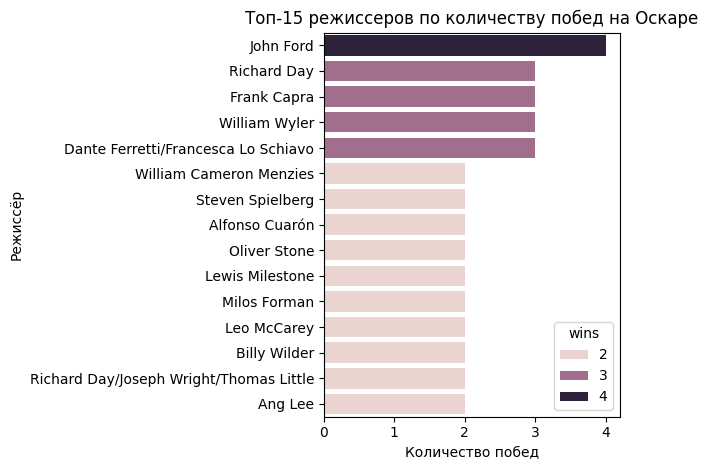

In [ ]:
directors = df[df['is_director']==True]
directors_with_most_nominations = directors.groupby('name', observed=True).size().sort_values(ascending=False).head(15)
print("\n Топ-15 самых номинируемых режиссеров:")
for i, (name, noms) in enumerate(directors_with_most_nominations.items()):
  print(f'{i+1}. {name} - {noms} номинаций')
directors_with_most_wins = directors.groupby('name', observed=True).agg(
    nominations=('winner', 'count'),
    wins = ('winner', 'sum')
).reset_index().sort_values(by='wins', ascending=False).head(15)

sns.barplot(data=directors_with_most_wins, x='wins', y='name', hue='wins')
plt.title('Топ-15 режиссеров по количеству побед на Оскаре')
plt.xlabel('Количество побед')
plt.ylabel('Режиссёр')
plt.tight_layout()
plt.show()

##3.14. "Вечные номинанты": режиссеры с множеством номинаций без побед

In [ ]:
eternal_directors = df[df['is_director']==True].groupby('name', observed=True).agg(
    nominations=('winner', 'count'),
    wins=('winner', 'sum')
).reset_index().sort_values(by='nominations', ascending=False)
eternal_directors = eternal_directors[eternal_directors['wins']==0].head(15)
print(eternal_directors)

                            name  nominations  wins
143               Clarence Brown            6     0
431                   King Vidor            5     0
608                Robert Altman            5     0
33              Alfred Hitchcock            5     0
49                    Anton Grot            5     0
279                  Hans Dreier            4     0
668              Stanley Kubrick            4     0
661                 Sidney Lumet            4     0
567                   Peter Weir            4     0
200             Federico Fellini            4     0
289  Hans Dreier/Roland Anderson            4     0
72                Bobby Connolly            4     0
531               Norman Jewison            3     0
87                Busby Berkeley            3     0
193               Ernst Lubitsch            3     0


##3.15. Анализ студийных достижений в разные исторические периоды

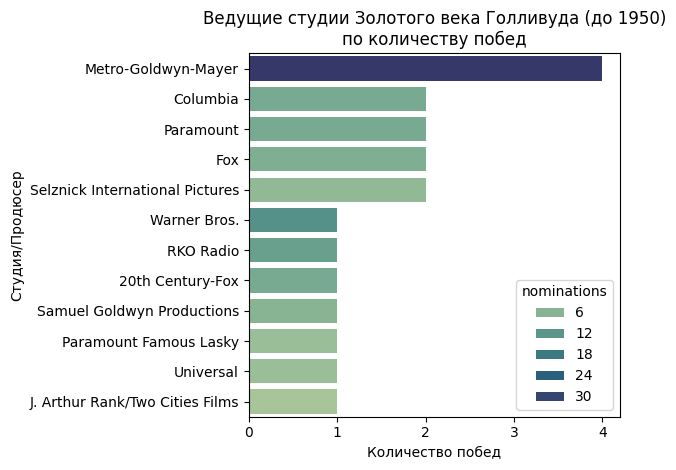

In [ ]:
studios = df[df['is_studio']==True]

# от студий-гигантов Золотого века Голливуда (MGM, Warner Bros) к независимым продюсерам
early_era = studios[studios['year_ceremony'] < 1950]
modern_era = studios[studios['year_ceremony'] >= 1950]

early_studios_with_most_nominations = early_era.groupby('name', observed=True).size().sort_values(ascending=False).reset_index(name='count').head(15)
early_studios_with_most_wins = early_era.groupby('name', observed=True).agg(
    nominations=('winner', 'count'),
    wins=('winner', 'sum')
).reset_index().sort_values(by=['wins', 'nominations'], ascending=[False, False])
early_studios_with_most_wins['win_rate'] = (100*early_studios_with_most_wins['wins'] / early_studios_with_most_wins['nominations']).round(2)
early_studios_with_most_wins = early_studios_with_most_wins[early_studios_with_most_wins['wins']>0]
sns.barplot(data=early_studios_with_most_wins, y='name', x='wins', hue='nominations', palette='crest')
plt.title('Ведущие студии Золотого века Голливуда (до 1950)\nпо количеству побед')
plt.xlabel('Количество побед')
plt.ylabel('Студия/Продюсер')
plt.tight_layout()
plt.show()

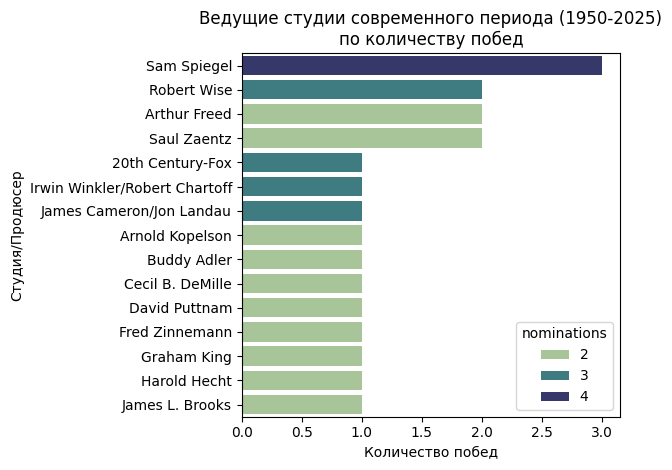

In [ ]:
modern_studios_with_most_nominations = modern_era.groupby('name', observed=True).size().sort_values(ascending=False).reset_index(name='count').head(15)
modern_studios_with_most_wins = modern_era.groupby('name', observed=True).agg(
    nominations=('winner', 'count'),
    wins=('winner', 'sum')
).reset_index().sort_values(by=['wins', 'nominations'], ascending=[False, False])
modern_studios_with_most_wins['win_rate'] = (100*modern_studios_with_most_wins['wins'] / modern_studios_with_most_wins['nominations']).round(2)
modern_studios_with_most_wins = modern_studios_with_most_wins[modern_studios_with_most_wins['wins']>0]
sns.barplot(data=modern_studios_with_most_wins.head(15), x='wins', y='name', hue='nominations', palette='crest')
plt.title('Ведущие студии современного периода (1950-2025)\nпо количеству побед')
plt.xlabel('Количество побед')
plt.ylabel('Студия/Продюсер')
plt.tight_layout()
plt.show()

##3.16. Сравнительный анализ эффективности студий в разные исторические периоды

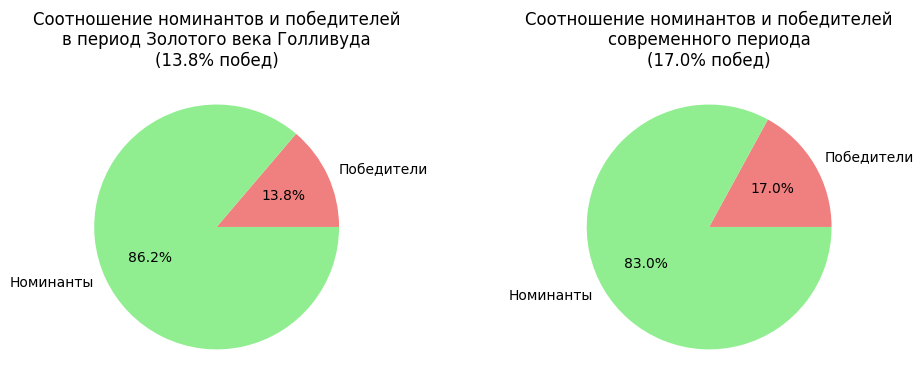

In [ ]:
early_era_win_data = early_era['winner'].value_counts().sort_values()
modern_era_win_data = modern_era['winner'].value_counts().sort_values()
early_win_rate = round(100*len(early_era[early_era['winner']==True]) / len(early_era), 1)
modern_win_rate = round(100*len(modern_era[modern_era['winner']==True]) / len(modern_era), 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pie(early_era_win_data.values, labels=['Победители', 'Номинанты'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title(f'Соотношение номинантов и победителей\nв период Золотого века Голливуда\n({early_win_rate:.1f}% побед)')
plt.subplot(1, 2, 2)
plt.pie(modern_era_win_data.values, labels=['Победители', 'Номинанты'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title(f'Соотношение номинантов и победителей\nсовременного периода\n({modern_win_rate:.1f}% побед)')
plt.tight_layout()
plt.show()

##3.17. Лидеры студийных категорий в разные исторические эпохи
Анализируем студии-лидеры в каждой исторической эпохе по двум критериям:
1. Студии с наибольшим количеством номинаций (топ-3 в каждой эпохе)
2. Абсолютные лидеры по количеству побед (топ-1 в каждой эпохе)

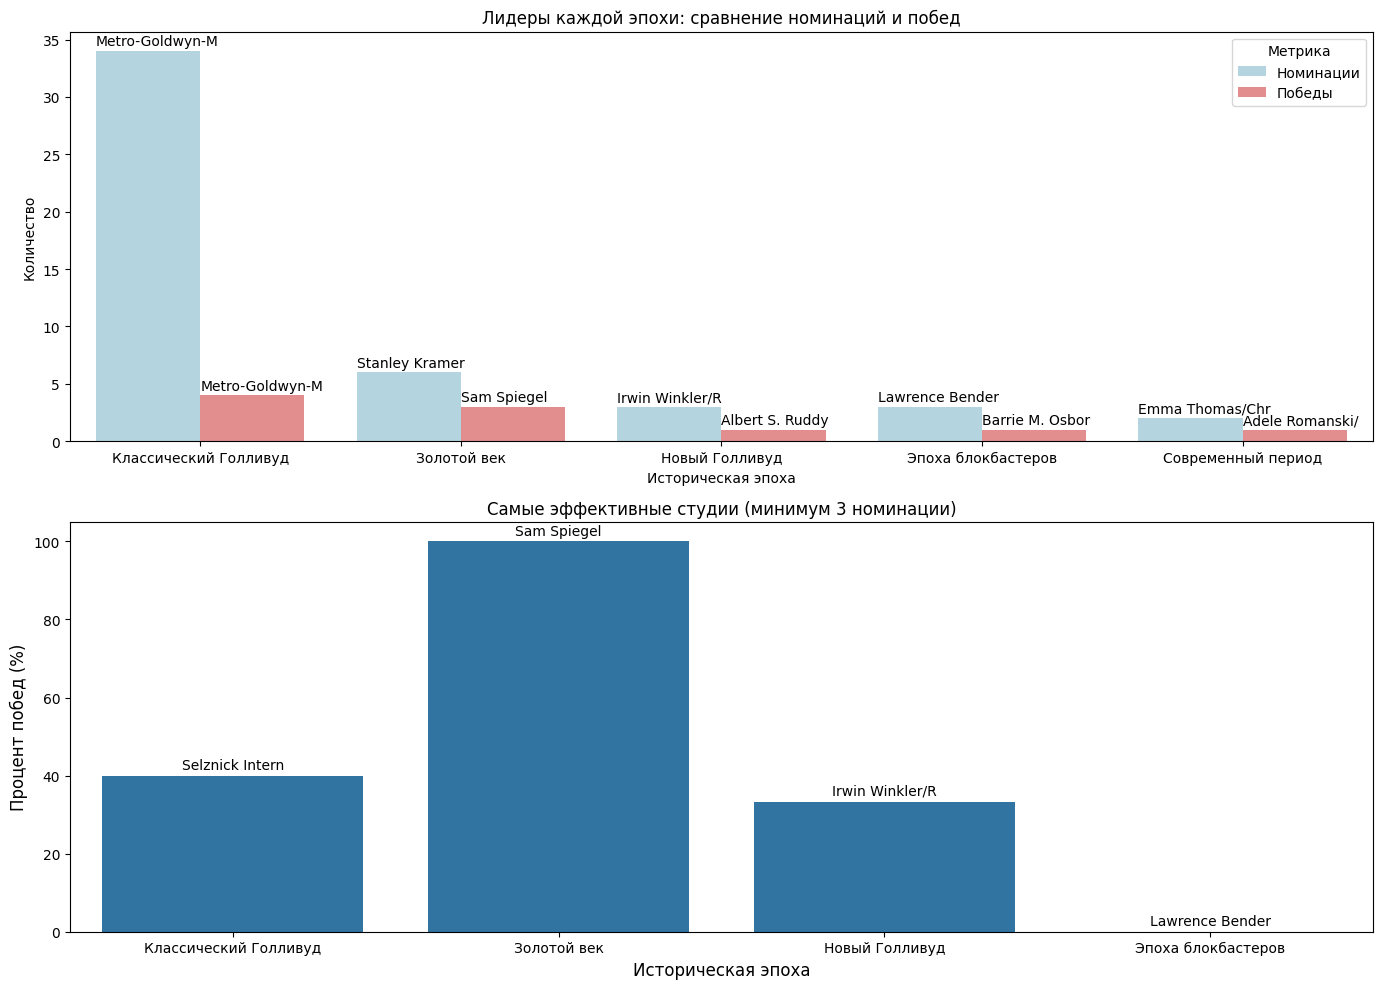

In [ ]:
eras_studios = studios.groupby(['era', 'name'], observed=True).agg(
    nominations=('winner', 'count'),
    wins=('winner', 'sum')
).reset_index()
eras_studios['efficiency'] = (100 * eras_studios['wins'] / eras_studios['nominations']).round(1)
studio_leaders_by_era = []
for era in eras_studios['era'].unique():
  era_data = eras_studios[eras_studios['era']==era]
  nom_leader = era_data.nlargest(1, 'nominations').iloc[0]
  wins_leader = era_data.nlargest(1, 'wins').iloc[0]
  eff_leader = era_data[era_data['nominations']>=3].nlargest(1, 'efficiency')
  if not eff_leader.empty:
    eff_leader = eff_leader.iloc[0]
  else:
    eff_leader = None
  studio_leaders_by_era.append({
      'era': era,
      'nominations_leader': nom_leader['name'],
      'nominations_count': nom_leader['nominations'],
      'wins_leader': wins_leader['name'],
      'wins_count': wins_leader['wins'],
      'efficiency_leader': eff_leader['name'] if eff_leader is not None else 'Н/Д',
      'efficiency_rate': eff_leader['efficiency'] if eff_leader is not None else 'Н/Д'
  })
leaders_df = pd.DataFrame(studio_leaders_by_era)
leaders_noms_wins = pd.melt(
    leaders_df,
    id_vars=['era', 'nominations_leader', 'wins_leader'],
    value_vars=['nominations_count', 'wins_count'],
    var_name='metric_type',
    value_name='count'
)
leaders_noms_wins['metric_type'] = leaders_noms_wins['metric_type'].replace({'nominations_count': 'Номинации', 'wins_count': 'Победы'})
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
ax1 = axes[0]
sns.barplot(data=leaders_noms_wins, x='era', y='count', hue='metric_type', palette=['lightblue', 'lightcoral'], ax=ax1)
ax1.set_xlabel('Историческая эпоха')
ax1.set_ylabel('Количество')
ax1.set_title('Лидеры каждой эпохи: сравнение номинаций и побед')
ax1.legend(title='Метрика')

bar_width = 0.35
for i, row in leaders_df.iterrows():
  x_noms = i-0.4
  x_wins = i

  ax1.text(x_noms, row['nominations_count']+0.5, row['nominations_leader'][:15])
  ax1.text(x_wins, row['wins_count']+0.5, row['wins_leader'][:15])

ax2 = axes[1]
effective_eras = leaders_df[leaders_df['efficiency_rate']!='Н/Д'].copy()
if len(effective_eras) > 0:
  effective_eras.loc[:, 'efficiency_rate'] = pd.to_numeric(
      effective_eras['efficiency_rate'],
      errors='coerce'
  )
  effective_eras = effective_eras.dropna(subset='efficiency_rate')
  if len(effective_eras) > 0:
    sns.barplot(data=effective_eras, x='era', y='efficiency_rate', ax=ax2)
    ax2.set_xlabel('Историческая эпоха', fontsize=12)
    ax2.set_ylabel('Процент побед (%)', fontsize=12)
    ax2.set_title('Самые эффективные студии (минимум 3 номинации)')
    for i, (index, row) in enumerate(effective_eras.iterrows()):
      ax2.text(i, row['efficiency_rate']+1, row['efficiency_leader'][:15], ha='center', va='bottom')

plt.tight_layout()
plt.show()

##3.18. Анализ изменчивости процента побед по годам

Статистика процента побед по годам:
Средний процент побед: 23.6
Медианный процент побед: 23.8
Стандартное отклонение: 3.7
Диапазон: 14.3 - 43.9


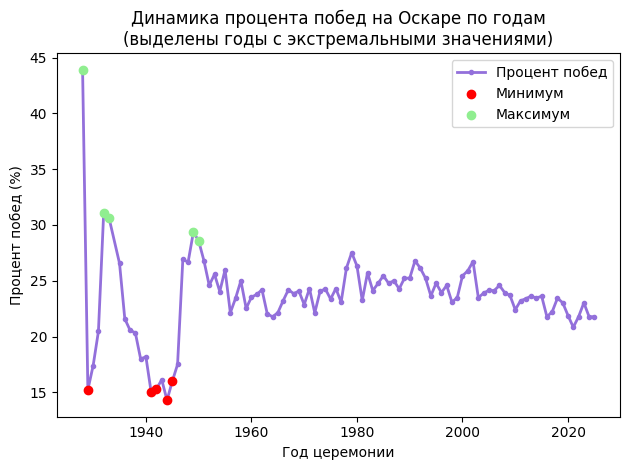

In [ ]:
# Годы с высоким/низким процентом побед
year_df = df.groupby('year_ceremony', observed=True).agg(
    nominations=('winner', 'count'),
    wins=('winner', 'sum')
).reset_index()

# Топ-5 лет с самым низким/высоким процентом побед
year_df['win_percentage'] = (100*year_df['wins']/year_df['nominations']).round(2)
year_with_min_percentage = year_df.nsmallest(5, 'win_percentage')
year_with_max_percentage = year_df.nlargest(5, 'win_percentage')
print('Статистика процента побед по годам:')
print(f'Средний процент побед: {year_df['win_percentage'].mean():.1f}')
print(f'Медианный процент побед: {year_df['win_percentage'].median():.1f}')
print(f'Стандартное отклонение: {year_df['win_percentage'].std():.1f}')
print(f'Диапазон: {year_df['win_percentage'].min():.1f} - {year_df['win_percentage'].max():.1f}')

plt.plot(year_df['year_ceremony'], year_df['win_percentage'], lw=2, marker='o', color='mediumpurple', ms=3, label='Процент побед')
plt.scatter(x=year_with_min_percentage['year_ceremony'], y=year_with_min_percentage['win_percentage'], marker='o', c='red', zorder=2, label='Минимум')
plt.scatter(x=year_with_max_percentage['year_ceremony'], y=year_with_max_percentage['win_percentage'], marker='o', c='lightgreen', zorder=2, label='Максимум')
plt.title('Динамика процента побед на Оскаре по годам\n(выделены годы с экстремальными значениями)')
plt.xlabel('Год церемонии')
plt.ylabel('Процент побед (%)')
plt.legend()
plt.tight_layout()
plt.show()

##3.19. Анализ взаимосвязей между категориями Оскара
Исследуем, какие категории премии Оскар статистически связаны между собой. Корреляционный анализ показывает, победы в каких категориях чаще всего сопровождаются победами в других категориях, что может указывать на определенные паттерны успеха фильмов.

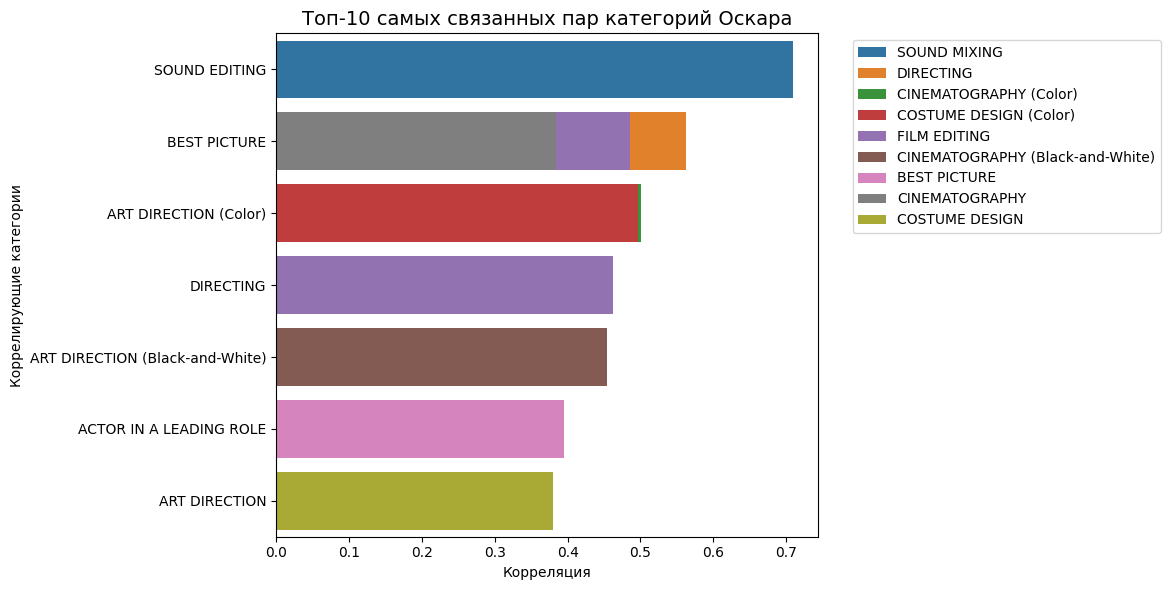

In [ ]:
film_category_matrix = df.pivot_table(
    index='film',
    columns='category',
    values='winner',
    aggfunc='count',
    fill_value=0
)

matrix_corr = film_category_matrix.corr()
corr_pairs = matrix_corr.unstack().sort_values(ascending=False)
corr_pairs.index = corr_pairs.index.set_names(['category1', 'category2'])
corr_pairs = corr_pairs.reset_index(name='correlation')
corr_pairs = corr_pairs[(corr_pairs['correlation']<0.99) & (corr_pairs['category1']<corr_pairs['category2'])]

top_10 = corr_pairs.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10, x='correlation', y='category1', hue='category2', dodge=False)
plt.title('Топ-10 самых связанных пар категорий Оскара', fontsize=14)
plt.xlabel('Корреляция')
plt.ylabel('Коррелирующие категории')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

#4. Подготовка данных для машинного обучения

##4.1. Создание дополнительных признаков для ML модели

In [ ]:
sorted_df = df.sort_values(by=['name', 'year_ceremony'])
sorted_df['nominee_prev_noms'] = sorted_df.groupby('name').cumcount()
sorted_df['nominee_prev_wins'] = sorted_df.groupby('name')['winner'].cumsum() - sorted_df['winner']
sorted_df['nominee_prev_win_rate'] = (100*sorted_df['nominee_prev_wins'] / sorted_df['nominee_prev_noms']).round(2)
ml_df = sorted_df
ml_df['years_since_last_nomination'] = ml_df.groupby('name')['year_ceremony'].diff()
ml_df['years_since_last_nomination'] = ml_df['years_since_last_nomination'].fillna(0)
ml_df['film_noms_this_year'] = ml_df.groupby(['year_ceremony', 'film'])['film'].transform('count')
ml_df['category_competitiveness'] = ml_df.groupby(['year_ceremony', 'category'])['category'].transform('count')
ml_df['cat_prev_noms'] = ml_df.groupby('category').cumcount()
ml_df['cat_prev_wins'] = ml_df.groupby('category')['winner'].cumsum() - ml_df['winner']
ml_df['cat_prev_win_rate'] = (100*ml_df['cat_prev_wins']/ml_df['cat_prev_noms']).round(2)
ml_df['nominee_prev_noms'] = ml_df['nominee_prev_noms'].fillna(0)
ml_df['nominee_prev_wins'] = ml_df['nominee_prev_wins'].fillna(0)
ml_df['nominee_prev_win_rate'] = ml_df['nominee_prev_win_rate'].fillna(0)

In [ ]:
print(ml_df.shape)
print(ml_df.isnull().sum())

(11110, 25)
year_film                        0
year_ceremony                    0
ceremony                         0
category                         0
canon_category                   0
name                             7
film                           359
winner                           0
decade                           0
era                              0
category_type                    0
actor_actress                    0
gender                           0
is_director                      0
is_studio                        0
is_major_cat                     0
nominee_prev_noms                0
nominee_prev_wins                0
nominee_prev_win_rate            0
years_since_last_nomination      0
film_noms_this_year            359
category_competitiveness         0
cat_prev_noms                    0
cat_prev_wins                    0
cat_prev_win_rate              118
dtype: int64


##4.2. Обработка пустых значений

In [ ]:
ml_df = ml_df[(ml_df['film'].notna()) & (ml_df['name'].notna())]
ml_df['cat_prev_win_rate'] = ml_df['cat_prev_win_rate'].fillna(0)
print(ml_df.isnull().sum())

year_film                      0
year_ceremony                  0
ceremony                       0
category                       0
canon_category                 0
name                           0
film                           0
winner                         0
decade                         0
era                            0
category_type                  0
actor_actress                  0
gender                         0
is_director                    0
is_studio                      0
is_major_cat                   0
nominee_prev_noms              0
nominee_prev_wins              0
nominee_prev_win_rate          0
years_since_last_nomination    0
film_noms_this_year            0
category_competitiveness       0
cat_prev_noms                  0
cat_prev_wins                  0
cat_prev_win_rate              0
dtype: int64


##4.3. Создание признаков (включая категориальные)

In [ ]:
from sklearn.preprocessing import LabelEncoder

category_mean = ml_df.groupby('category')['winner'].transform('mean')
ml_df['category_mean'] = category_mean
le = LabelEncoder()
ml_df['le_decade'] = le.fit_transform(ml_df['decade'])
era_dummies = pd.get_dummies(ml_df['era'], drop_first=True)
ml_df = pd.concat([ml_df, era_dummies], axis=1)
ml_df['had_previous_noms'] = (ml_df['nominee_prev_noms']>0).astype(int)
ml_df['had_previous_wins'] = (ml_df['nominee_prev_wins']>0).astype(int)
ml_df['lot_of_noms'] = (ml_df['film_noms_this_year']>7).astype(int)
ml_df['film_experience'] = (ml_df['lot_of_noms'] & ml_df['had_previous_wins']).astype(int)
ml_df['few_years_since_last_nom'] = (ml_df['years_since_last_nomination']<5)
ml_df['film_power'] = pd.cut(ml_df['film_noms_this_year'], bins=[-1, 0, 5, 9, 14], labels=['weak', 'med', 'strong', 'super'])
ml_df['film_and_cat'] = ml_df['film_noms_this_year'] * ml_df['category_competitiveness']
ml_df['cat_total'] = ml_df['category_competitiveness'] * ml_df['is_major_cat']
ml_df['comeback'] = (ml_df['years_since_last_nomination']>5).astype(int)
film_power_dummies = pd.get_dummies(ml_df['film_power'], drop_first=True)
ml_df = pd.concat([ml_df, film_power_dummies], axis=1)
print(ml_df.columns)

Index(['year_film', 'year_ceremony', 'ceremony', 'category', 'canon_category',
       'name', 'film', 'winner', 'decade', 'era', 'category_type',
       'actor_actress', 'gender', 'is_director', 'is_studio', 'is_major_cat',
       'nominee_prev_noms', 'nominee_prev_wins', 'nominee_prev_win_rate',
       'years_since_last_nomination', 'film_noms_this_year',
       'category_competitiveness', 'cat_prev_noms', 'cat_prev_wins',
       'cat_prev_win_rate', 'category_mean', 'le_decade', 'Золотой век',
       'Новый Голливуд', 'Эпоха блокбастеров', 'Современный период',
       'had_previous_noms', 'had_previous_wins', 'lot_of_noms',
       'film_experience', 'few_years_since_last_nom', 'film_power',
       'film_and_cat', 'cat_total', 'comeback', 'med', 'strong', 'super'],
      dtype='object')


##4.4. Итоговые признаки

In [ ]:
features = [
    'nominee_prev_noms', 'nominee_prev_win_rate',
    'years_since_last_nomination', 'film_noms_this_year',
    'category_competitiveness', 'Золотой век',
    'Новый Голливуд', 'Эпоха блокбастеров', 'Современный период',
    'had_previous_noms', 'had_previous_wins', 'lot_of_noms',
    'film_experience', 'film_and_cat', 'cat_total',
    'comeback', 'med', 'strong', 'super'
]
bool_cols = ml_df[features].select_dtypes(include=['bool']).columns
for i in bool_cols:
  ml_df[i] = ml_df[i].astype(int)

#5. Обучение модели

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

X = ml_df[features]
y = ml_df['winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote =SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 5],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)
gridRF = GridSearchCV(rf, rf_params, cv=5, scoring='roc_auc')
gridRF.fit(X_train_bal, y_train_bal)

print(gridRF.best_params_)
print(gridRF.best_score_)

best_rf = gridRF.best_estimator_

{'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
0.8114109352690072


#6. Оценка качества модели

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

predictions = best_rf.predict(X_test)
pred_proba = best_rf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, predictions))
print(roc_auc_score(y_test, pred_proba))

              precision    recall  f1-score   support

       False       0.84      0.77      0.80      2579
        True       0.31      0.41      0.35       645

    accuracy                           0.70      3224
   macro avg       0.57      0.59      0.58      3224
weighted avg       0.73      0.70      0.71      3224

0.6219933812456604


#7. Анализ важности признаков

In [ ]:
feature_importance = pd.DataFrame({
    'feature': X_train_bal.columns,
    'importance': best_rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importance)

                        feature  importance
13                 film_and_cat    0.136834
3           film_noms_this_year    0.130653
4      category_competitiveness    0.127015
2   years_since_last_nomination    0.114804
0             nominee_prev_noms    0.105373
14                    cat_total    0.060776
1         nominee_prev_win_rate    0.048126
5                   Золотой век    0.039528
16                          med    0.036238
7            Эпоха блокбастеров    0.036084
8            Современный период    0.034600
6                Новый Голливуд    0.032683
11                  lot_of_noms    0.032131
9             had_previous_noms    0.014552
10            had_previous_wins    0.012631
15                     comeback    0.012557
17                       strong    0.011448
18                        super    0.010405
12              film_experience    0.003562
